In [1]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Helpers
import os
import sys
sys.path.insert(0,'../')
from utils import data_path, raw_train_data_path, raw_test_data_path
from scipy.special import digamma,betaln
import time

# Prediction
from math import log
from scipy.special import beta, comb
from math import exp

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score,confusion_matrix
from sklearn.model_selection import LeaveOneOut,KFold

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# import plotly
# plotly.tools.set_credentials_file(username='tracyqin326', api_key='EICCf5vuIzI5hVfA4gYC')
# import plotly.plotly as py
# import plotly.graph_objs as go

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Model

### Class-Wise Priors

#### Gradient ascent

gradient ascent methods were used to determine the class-wise beta priors (Maximizing the objective functions (log likellihood dropping terms dependent only on the data)  

In [2]:
# objective function that to be maximized
def objective(n,k,indices,N_class,a,b):
    
#     n = df['unique_TCRs'].tolist()
#     k = df['CMV_associated_TCRs'].tolist()
#     indices = df[df['CMV_status']==_class].index
#     N_class = len(indices)
    
    sum_log_beta = 0
    for i in indices:
#         sum_log_beta += log(beta(k[i]+a,n[i]-k[i]+b))
        sum_log_beta += betaln(k[i]+a,n[i]-k[i]+b)
#     objective = -N_class*log(beta(a,b))+sum_log_beta
    objective = -N_class*betaln(a,b)+sum_log_beta
    
    return objective

def objective_norm(df,_class,a,b):
    
    n = df['unique_TCRs'].tolist()
    k = df['CMV_associated_TCRs'].tolist()
    indices_0 = df[df['CMV_status']==0].index
    indices_1 = df[df['CMV_status']==1].index
    N_0 = len(indices_0)
    N_1 = len(indices_1)
    
    obj_c0 = objective(n,k,indices_0,N_0,a,b)
    obj_c1 = objective(n,k,indices_1,N_1,a,b)
    obj = [obj_c0,obj_c1]
    
    obj_norm = obj[_class]/(obj[0]+obj[1])
    
    return obj_norm

# gradient ascent to maximizing the objective function
def gradient_ascent(a,b,df,_class,learning_rate,precision,max_iterations):

    df.reset_index(drop=True,inplace=True)
    a_list = []
    b_list = []
    obj = []
    
    old_a = a+precision-1
    old_b = b+precision-1
    iterations = 0
    
    n = df['unique_TCRs'].tolist()
    k = df['CMV_associated_TCRs'].tolist()
    indices = df[df['CMV_status']==_class].index
    N_class = len(indices)
    
    while abs(a-old_a)>precision or abs(b-old_b)>precision:
        
        old_a = a
        old_b = b
        sum_a = 0
        sum_b = 0
        obj.append(objective_norm(df,_class,a,b))

        for index in indices:
            sum_a += digamma(k[index]+a)-digamma(n[index]+k[index]+a+b)
            sum_b += digamma(n[index]-k[index]+b)-digamma(n[index]+k[index]+a+b)
        
        gradient_a = -N_class*(digamma(a)-digamma(a+b))+sum_a
        gradient_b = -N_class*(digamma(b)-digamma(a+b))+sum_b
    
        a += learning_rate*gradient_a
        b += learning_rate*gradient_b
            
        a_list.append(a)
        b_list.append(b)
        
        iterations += 1
        if iterations == max_iterations:
            break
    
    if iterations == max_iterations:
        print('Go through the max %d iterations'%(max_iterations))
    else:
        print('Go trhough %d iterations'%(iterations))
        
    print('Parameter a and b:',a,b)
    
    return a,b,a_list,b_list,obj

#### Determine parameters of class-wise beta priors

In [5]:
#Load statistics of TCRs of training set
train = pd.read_csv('../data/'+'CMV/MAP_estimator/'+'train_neg.csv')
train.head()

,sample_name,unique_TCRs,CMV_status,1e-06,1e-05,0.0001,0.001,0.01,0.1
0,HIP09097,123638,0,0,0,3,29,277,3569
1,HIP05561,153097,0,0,1,4,42,339,4189
2,HIP13856,277546,1,0,1,2,26,187,2538
3,HIP05398,218577,0,0,1,8,64,477,6057
4,HIP13975,286379,1,0,0,1,27,222,2636


### threshold = 0.0001

In [6]:
statistics_TCRs_train = train.drop(['1e-06','1e-05','0.001','0.01','0.1'],axis=1)
statistics_TCRs_train.rename(index=str, columns={'0.0001':'CMV_associated_TCRs' },inplace=True)

In [8]:
statistics_TCRs_train.mean()

unique_TCRs            193665.992200
CMV_status                  0.450858
CMV_associated_TCRs         3.700468
dtype: float64

In [9]:
statistics_TCRs_train.std()

unique_TCRs            80495.702609
CMV_status                 0.497968
CMV_associated_TCRs        2.516970
dtype: float64

In [10]:
statistics_TCRs_train[statistics_TCRs_train.CMV_status==0].mean()

unique_TCRs            198229.846591
CMV_status                  0.000000
CMV_associated_TCRs         4.997159
dtype: float64

In [11]:
statistics_TCRs_train[statistics_TCRs_train.CMV_status==1].mean()

unique_TCRs            188107.249135
CMV_status                  1.000000
CMV_associated_TCRs         2.121107
dtype: float64

In [12]:
train_X = statistics_TCRs_train.drop(['sample_name','CMV_status'],axis=1)
train_y = statistics_TCRs_train['CMV_status'] 

Text(0.5,1,'CMV-status classification')

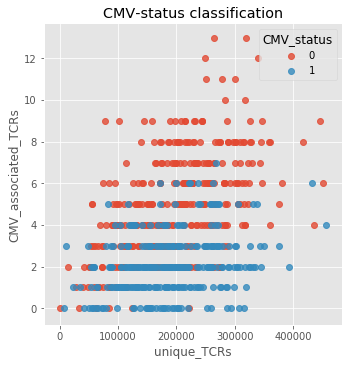

In [13]:
lm = sns.lmplot(data=statistics_TCRs_train,x='unique_TCRs',y='CMV_associated_TCRs',
                           hue='CMV_status',fit_reg=False,legend=True,legend_out=False)
ax = plt.gca()
ax.set_title('CMV-status classification')

In [14]:
# paramter initialization
# params_c0 = [25,2800000]
# params_c1 = [3,50000]
a = [27,27]
b = [1400000,2800000]

In [15]:
start = time.time()
a0,b0,a0_list,b0_list,obj_0 = gradient_ascent(a[0],b[0],statistics_TCRs_train,0,1e-2,1e-6,10000)
end = time.time()
print('Time:',(end-start))

Go through the max 10000 iterations
Parameter a and b: 35.64264490958462 1399999.8910777008
Time: 46.38416814804077


In [16]:
start = time.time()
a1,b1,a1_list,b1_list,obj_1 = gradient_ascent(a[1],b[1],statistics_TCRs_train,1,1e-2,1e-6,10000)
end = time.time()
print('Time:',(end-start))

Go through the max 10000 iterations
Parameter a and b: 31.753832021243305 2799999.9795267023
Time: 42.56839919090271


In [ ]:
# fig,axes = plt.subplots(2,2,figsize=(12,4))
# axes[0][0].plot(a0_list)
# axes[0][0].set_xlabel('iteration')
# axes[0][0].set_ylabel('a0')

# axes[0][1].plot(b0_list)
# axes[0][1].set_xlabel('iteration')
# axes[0][1].set_ylabel('b0')

# axes[1][0].plot(a1_list)
# axes[1][0].set_xlabel('iteration')
# axes[1][0].set_ylabel('a1')

# axes[1][1].plot(b1_list)
# axes[1][1].set_xlabel('iteration')
# axes[1][1].set_ylabel('b1')

In [ ]:
# fig,axes = plt.subplots(1,2,figsize=(12,4))
# axes[0].plot(obj_0)
# axes[1].plot(obj_1)

In [17]:
# parameters of beta priors
a = [a0,a1]
b = [b0,b1]

print(a)
print(b)

[35.64264490958462, 31.753832021243305]
[1399999.8910777008, 2799999.9795267023]


### Posterior

A decision function is defined by a threshold θ on the log-posterior odds ratio for class assignment 

In [18]:
# decision function
def predict(df,a,b,k,n):
    
    CMV_status_counts = df['CMV_status'].value_counts()
    N = [CMV_status_counts[0],CMV_status_counts[1]]
    
#     F = log(N[1]+1)-log(N[0]+1)+log(beta(a[0],b[0]))-log(beta(a[1],b[1]))+\
#         log(beta(k+a[1],n-k+b[1]))-log(beta(k+a[0],n-k+b[0]))
    F = log(N[1]+1)-log(N[0]+1)+betaln(a[0],b[0])-betaln(a[1],b[1])+\
        betaln(k+a[1],n-k+b[1])-betaln(k+a[0],n-k+b[0])
        
    if F<=0:
        predict = 0
    else:
        predict = 1
    
    return predict


# posterior probability
def posterior_prob(df,_class,a_class,b_class,n,k):
    
    N_total = len(df)
    N_class = len(df[df['CMV_status']==_class])
    
    p = comb(n,k) * (beta(k+a_class,n-k+b_class)/beta(a_class,b_class)) * ((N_class+1)/(N_total+2))
    
    return p

# posterior probability with normalizaiton
def post_prob_norm(df,_class,a,b,n,k):
    
    p_pos = posterior_prob(df,1,a[1],b[1],n,k)
    p_neg = posterior_prob(df,0,a[0],b[0],n,k)
    p = [p_neg,p_pos]
    
    p_class_norm = p[_class]/(p[0]+p[1])
    
    return p_class_norm

## Prediction

### Training set

**accuracy score**

In [19]:
train_pred = [predict(statistics_TCRs_train,a,b,row['CMV_associated_TCRs'],row['unique_TCRs']) 
           for _,row in statistics_TCRs_train.iterrows()]

train_y = statistics_TCRs_train['CMV_status']

print('accuracy score:',accuracy_score(train_y,train_pred))

accuracy score: 0.750390015600624


**AUROC**

In [20]:
train_post_pos = [post_prob_norm(statistics_TCRs_train,1,a,b,row['unique_TCRs'],row['CMV_associated_TCRs']) 
         for _,row in statistics_TCRs_train.iterrows()]

fpr_train,tpr_train,thresholds_train = roc_curve(train_y,train_post_pos,pos_label=1)
print('roc_auc_score:',roc_auc_score(train_y,train_post_pos))

roc_auc_score: 0.8414497483485373


**Cross Validation**

In [21]:
# loo = LeaveOneOut()

# cv_post_pos = []
# cv_y = []

# for train_index,test_index in loo.split(statistics_TCRs_train):
#     train, test = statistics_TCRs_train.iloc[train_index], statistics_TCRs_train.iloc[test_index]
#     post_pos = post_prob_norm(train,1,a,b,test['unique_TCRs'].tolist()[0],test['CMV_associated_TCRs'].tolist()[0])
#     cv_post_pos.append(post_pos)
#     cv_y.append(test['CMV_status'].tolist()[0])

# fpr_cv,tpr_cv,thresholds_cv = roc_curve(cv_y,cv_post_pos,pos_label=1)
# print('roc_auc_score:',roc_auc_score(cv_y,cv_post_pos))

In [ ]:
loo = LeaveOneOut()

cv_post_pos = []
cv_y = []



for train_index,test_index in loo.split(statistics_TCRs_train):
    train, test = statistics_TCRs_train.iloc[train_index], statistics_TCRs_train.iloc[test_index]
    
    a = [26,3]
    b = [2800000,50000]
    
    a0,b0,a0_list,b0_list,obj_0 = gradient_ascent(a[0],b[0],train,0,1e-2,1e-6,10000)
    a1,b1,a1_list,b1_list,obj_1 = gradient_ascent(a[1],b[1],train,1,1e-2,1e-6,10000)
    
    a = [a0,a1]
    b = [b0,b1]
    
    post_pos = post_prob_norm(train,1,a,b,test['unique_TCRs'].tolist()[0],test['CMV_associated_TCRs'].tolist()[0])
    
    cv_post_pos.append(post_pos)
    cv_y.append(test['CMV_status'].tolist()[0])

fpr_cv,tpr_cv,thresholds_cv = roc_curve(cv_y,cv_post_pos,pos_label=1)
print('roc_auc_score:',roc_auc_score(cv_y,cv_post_pos))

In [16]:
cv_auroc = []
cv_acc = []
kf = KFold(n_splits=10,random_state=0)
for train_index,test_index in kf.split(statistics_TCRs_train):
    a = [26,3]
    b = [2800000,50000]
    train_cv, test_cv = statistics_TCRs_train.iloc[train_index], statistics_TCRs_train.iloc[test_index]
    
    a0,b0,a0_list,b0_list,obj_0 = gradient_ascent(a[0],b[0],train_cv,0,1e-2,1e-6,50000)
    a1,b1,a1_list,b1_list,obj_1 = gradient_ascent(a[1],b[1],train_cv,1,1e-2,1e-6,50000)
    
    a = [a0,a1]
    b = [b0,b1]
    test_y = test_cv['CMV_status']
    
    test_post_pos = [post_prob_norm(train_cv,1,a,b,row['unique_TCRs'],row['CMV_associated_TCRs']) 
         for _,row in test_cv.iterrows()]
    
    test_pred = [predict(train_cv,a,b,row['CMV_associated_TCRs'],row['unique_TCRs']) 
           for _,row in test_cv.iterrows()]

    cv_auroc.append(roc_auc_score(test_y,test_post_pos))
    cv_acc.append(accuracy_score(test_y,test_pred))
print('mean cv auroc:',np.mean(cv_auroc))
print('mean cv acc:',np.mean(cv_acc))

Go through the max 50000 iterations
Parameter a and b: 27.115739803003258 2799999.9021306266
Go through the max 50000 iterations
Parameter a and b: 3.928530461106904 49992.15164906263
Go through the max 50000 iterations
Parameter a and b: 26.643502733517828 2799999.902926918
Go through the max 50000 iterations
Parameter a and b: 3.9986456064313023 49992.09296299538
Go through the max 50000 iterations
Parameter a and b: 27.58162931542779 2799999.898679848
Go through the max 50000 iterations
Parameter a and b: 3.8847281122420965 49992.39284417966
Go through the max 50000 iterations
Parameter a and b: 27.130646439120696 2799999.897567155
Go through the max 50000 iterations
Parameter a and b: 3.874857433725592 49992.538014763355
Go through the max 50000 iterations
Parameter a and b: 26.318302204858252 2799999.90199871
Go through the max 50000 iterations
Parameter a and b: 3.846367246616699 49992.41357064455
Go through the max 50000 iterations
Parameter a and b: 26.68309103414144 2799999.90

### Testing set

In [23]:
#Load statistics of TCRs of training set
test = pd.read_csv('../data/'+'CMV/MAP_estimator/'+'test_neg.csv')
statistics_TCRs_test =  test.drop(['1e-06','1e-05','0.001','0.01','0.1'],axis=1)
statistics_TCRs_test.rename(index=str, columns={'0.0001':'CMV_associated_TCRs' },inplace=True)
statistics_TCRs_test

,sample_name,unique_TCRs,CMV_status,CMV_associated_TCRs
0,Keck0113_MC1,462884,0,7
1,Keck0048_MC1,136737,0,5
2,Keck0004_MC1,124450,1,2
3,Keck0035_MC1,105739,1,3
4,Keck0066_MC1,124756,0,2
5,Keck0105_MC1,294290,0,5
6,Keck0086_MC1,200058,0,7
7,Keck0016_MC1,120836,0,7
8,Keck0108_MC1,143542,1,2
9,Keck0090_MC1,220699,1,6


In [24]:
statistics_TCRs_test.mean()

unique_TCRs            202918.358333
CMV_status                  0.425000
CMV_associated_TCRs         4.441667
dtype: float64

In [25]:
statistics_TCRs_test.std()

unique_TCRs            109058.554194
CMV_status                  0.496416
CMV_associated_TCRs         2.368547
dtype: float64

Text(0.5,1,'CMV-status classification-testing set')

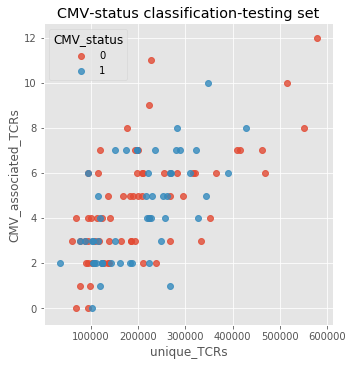

In [26]:
lm = sns.lmplot(data=statistics_TCRs_test,x='unique_TCRs',y='CMV_associated_TCRs',
                           hue='CMV_status',fit_reg=False,legend=True,legend_out=False)
ax = plt.gca()
ax.set_title('CMV-status classification-testing set')

**accuracy score**

In [27]:
# predict 

test_pred = [predict(statistics_TCRs_train,a,b,row['CMV_associated_TCRs'],row['unique_TCRs']) 
           for _,row in statistics_TCRs_test.iterrows()]

test_y = statistics_TCRs_test['CMV_status']

print('accuracy score:',accuracy_score(test_y,test_pred))

accuracy score: 0.55


**confusion matrix**

In [28]:
confusion_matrix(test_y,test_pred)

array([[53, 16],
       [38, 13]])

**AUROC**

In [29]:
# (normalized) posteriror probabilities 
test_post_pos = [post_prob_norm(statistics_TCRs_train,1,a,b,row['unique_TCRs'],row['CMV_associated_TCRs']) 
         for _,row in statistics_TCRs_test.iterrows()]

test_post_neg = [post_prob_norm(statistics_TCRs_train,0,a,b,row['unique_TCRs'],row['CMV_associated_TCRs']) 
         for _,row in statistics_TCRs_test.iterrows()]

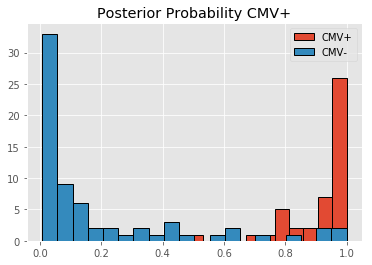

In [58]:
# posterior probability on CMV+
test_pred_df = pd.DataFrame({'true_label':test_y,'posterior_proba_CMV+':test_post_pos,
                             'posterior_proba_CMV-':test_post_neg})
CMV_pos_post = test_pred_df[test_pred_df['true_label']==1]['posterior_proba_CMV+']
CMV_neg_post = test_pred_df[test_pred_df['true_label']==0]['posterior_proba_CMV+']

# histograms of the posteriror probabilities
plt.hist(CMV_pos_post,edgecolor='black', bins=20,linewidth=1,label='CMV+')
plt.hist(CMV_neg_post,edgecolor='black', bins=20,linewidth=1,label='CMV-')
plt.title('Posterior Probability CMV+')
plt.legend(loc='best')

In [30]:
# AUC ROC
fpr_test,tpr_test,thresholds_test = roc_curve(test_y,test_post_pos,pos_label=1)
print('roc_auc_score:',roc_auc_score(test_y,test_post_pos))

roc_auc_score: 0.5271383915885195
